# Cat Dog Classifier Network Training
In this notebook I will use keras to train a neural network to identify pictures of cats and dogs. I will look at the accuracy reached and training time of different network structures.

## Setup
I first need to import everything that is used and seed the random numbers for reproducibility. An array is also initialized to record the results of each network.

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import time

results = []

Using TensorFlow backend.


## Basics
I need to setup the general method I will be using to train. I will normalize the image size, set the epoch count, batch size, and the location of the data.
The data should be structured as follows.
```
../
    ThisFile.py
    cats_and_dogs_filtered/
       train/
           cats/
               images...
           dogs/
               images...
       validation/
           cats/
               images...
           dogs/
               images...
       vectorize.py
```

In [2]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = './cats_and_dogs_filtered/train'
validation_data_dir = './cats_and_dogs_filtered/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 15
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Data
The data needs to be preprocessed and stored. I set up a preprocess for the training data that has a large amount of randomization. This is to avoid overfitting and to vary the dataset more. I both cases I rescale the pixels to contain data between 0-1 as opposed to 0-255.


In [3]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Helpers
This is a function to plot the accuracy of a network over time as it is trained and a class to record epoch time. I will use the both later.

In [4]:
def plotacc(history):
    # Plot training & validation accuracy values
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def train(name, model):
    model.summary()

    # Compiling the CNN
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

    time_callback = DataRecord(name)

    record = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        verbose = 0,
        callbacks = [time_callback])

    time_callback.history = record.history
    time_callback.acc = record.history["acc"][-1]
    print ("Training Time:", sum(time_callback.times))
    print ("Accuracy:", time_callback.acc)
    plotacc(record.history)
    results.append(time_callback)
    
class DataRecord(keras.callbacks.Callback):
    def __init__(self, name):
        self.name = name
    
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Network structure
I will experiment with different structures to compare the results against this problem. In all structures I will have certain things I will not change. I will have relu activation for all layers but the last and I will use sigmoid for the output layer because the problem is of binary classification. I will be using rmsprop as my optimizer for all training as I found that it yields better results in all scenarios. I will use the same preprocessing of images for each network.

# Simple network
Training with a single convolutional layer with a small mask and a dense layer to use the data yields these results.

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 700928)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 700929    
Total params: 701,825
Trainable params: 701,825
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Training Time: 721.6662120819092
Accuracy: 0.5


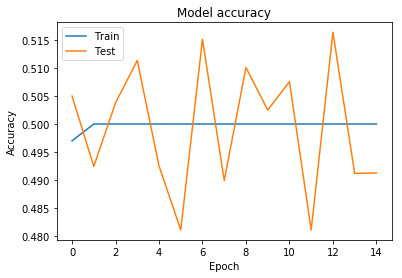

In [5]:
K.clear_session()

# Initialising the CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(Flatten())
model.add(Dense(units = 1, activation = 'sigmoid'))

train("Simple Network", model)

## Max pooling layer
Using the same structure as before but with a maxpooling layer to reduce the number of inputs to the dense layer by a factor of four. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 175233    
Total params: 176,129
Trainable params: 176,129
Non-trainable params: 0
_________________________________________________________________
Training Time: 767.104218006134
Accuracy: 0.722


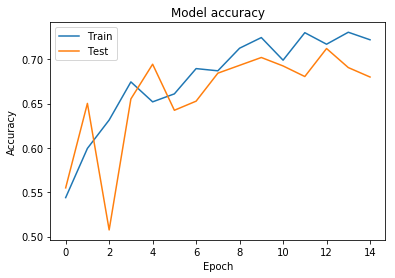

In [6]:
K.clear_session()

# Initialising the CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 1, activation = 'sigmoid'))

train("Maxpooling", model)

## Convolutional-Maxpooling layer sets
Using a different number of sets of a convolutional layer then a maxpooling layer leads to varying results

### Two Sets

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41473     
Total params: 51,617
Trainable params: 51,617
Non-trainable params: 0
_________________________________________________________________
Traini

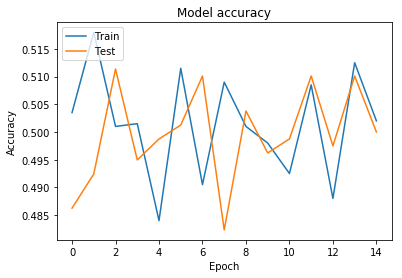

In [7]:
K.clear_session()

# Initialising the CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 1, activation = 'sigmoid'))

train("Sets 2", model)

### Three Sets

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

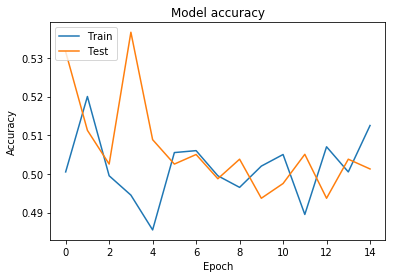

In [8]:
K.clear_session()

# Initialising the CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 1, activation = 'sigmoid'))

train("Sets 3", model)

## Ending with dense layers
While the previous networks only had a single fully connected layer at the end of the network there may be an advantage to having a larger layer after the convolutional-maxpooling sets.

### Two Sets (Dense end)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2654272   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total para

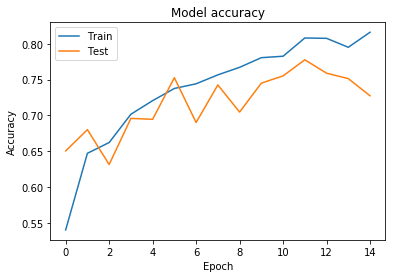

In [9]:
K.clear_session()

# Initialising the CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

train("Sets 2 (Dense end)", model)

### Three Sets (Dense end)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

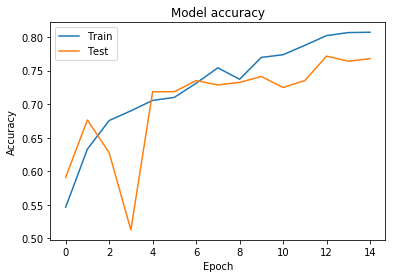

In [10]:
K.clear_session()

# Initialising the CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

train("Sets 3 (Dense end)", model)

In [11]:
for x in results:
    print("{} had a final accuracy of {} and an average training time of {} per epoch.".format(x.name, x.acc, round(sum(x.times)/epochs)))

Simple Network had a final accuracy of 0.5 and an average training time of 48 per epoch.
Maxpooling had a final accuracy of 0.722 and an average training time of 51 per epoch.
Sets 2 had a final accuracy of 0.502 and an average training time of 67 per epoch.
Sets 3 had a final accuracy of 0.5125 and an average training time of 70 per epoch.
Sets 2 (Dense end) had a final accuracy of 0.816 and an average training time of 69 per epoch.
Sets 3 (Dense end) had a final accuracy of 0.807 and an average training time of 77 per epoch.


# Results
As can be seen the network with three sets of convolutional and maxpooling layers and a fully connected layer before the output had the best accuracy while the smallest network with only a single convolutional layer and a one neuron output had the fastest training time. Given that the training time was not unreasonable per epoch and that this was run using a CPU if one were going for accuracy levels above 80% should be achievable with the three set dense end network quickly on a GPU especially if more randomization takes place in the preprocessing of the training data.

# Final Network
Using this information the best network under the curqumstances is shown and trained below.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
__________

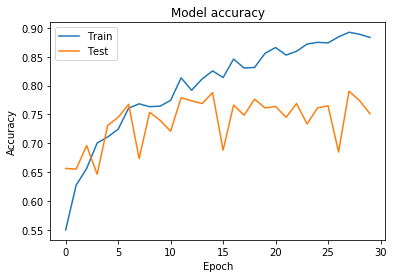

In [12]:
epochs = 30
# Initialising the CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

train("Sets 3 (Dense end)", model)

After 30 epochs the validation data achieves an accuracy of about 75% after 30 minutes of training.

## Saving the network
To use the network elsewhere it needs to be saved. The newly trained and saved network can now be loaded by a program and used to classify images.

In [ ]:
model.save("FinalNet.h5")